In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
from Secrest_dipole import SecrestDipole

In [4]:
mpl.rcParams['font.family'] = 'serif'

In [5]:
def EllisBaldwin(x, alpha, v=369.825*u.km/u.s):
    """
    Returns the expected dipole amplitude from Ellis & Baldwin (1984), given
        x = number-count slope at flux density limit
        alpha = source spectral index assuming power law spectra
    """
    return v / const.c.to(u.km/u.s) * (2 + x * (1+alpha))

In [6]:
def BR_Vega_to_AB(BR, offset=-0.3250):  # offset computed from Gaia photometric zero points
                                    # (Tables 5.2-5.3 in https://gea.esac.esa.int/archive/documentation/GDR2/ \
                                    # Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html )
    return BR + offset

In [7]:
def compute_alpha_gaia(BR, lambda_B=505.15, lambda_R=772.62):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - B = BP magnitude (Vega system)
    - R = RP magnitude (Vega system)
    - lambda_B = wavelength (nm) of blue passband (default is the "pivot wavelength" given by Gaia)
    - lambda_R = wavelength (nm) of red passband (")
    """
    # convert given (B-R)_Vega to AB color (B-R)_AB
    BR_AB = BR_Vega_to_AB(BR)
    
    alpha = BR_AB/(2.5*np.log10(lambda_R/lambda_B))

    return alpha

In [8]:
def W12_Vega_to_AB(W12, offset=-0.6400):
    return W12 + offset

In [9]:
def compute_alpha_wise(W12, lambda_W1=3.368, lambda_W2=4.618):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - W1 = W1 magnitude (Vega system)
    - W2 = W2 magnitude (Vega system)
    - lambda_W1 = wavelength (nm) of W1 passband (default is the "effective wavelength" of the band for a
                                                    signal with nu * F_nu = const. from 
                                                    https://www.astro.ucla.edu/~wright/WISE/passbands.html)
    - lambda_W2 = wavelength (nm) of W2 passband (")
    Note that the unit of wavelength doesn't matter here as long as it's the same in both bands.
    """
    # convert given (W1-W2)_Vega to AB color (W1-W2)_AB
    W12_AB = W12_Vega_to_AB(W12)
    
    alpha = W12_AB/(2.5*np.log10(lambda_W2/lambda_W1))

    return alpha

### Quaia

In [10]:
catname = 'quaia'
initial_catfn = 'quaia_G20.0_zsplit2bin0.fits'
mag = 'G'
maglim = 20.
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=30)
del d.initial_cattab
d.cut_mag()
# magnitudes
bprp = d.table['phot_bp_mean_mag'] - d.table['phot_rp_mean_mag']
# compute alphas
alphas = [compute_alpha_gaia(bprp[i]) for i in range(len(d.table))]
print(np.mean(alphas))

# with galactic plane masking
d.cut_galactic_plane()
bprp = d.table['phot_bp_mean_mag'] - d.table['phot_rp_mean_mag']
alphas_blim = [compute_alpha_gaia(bprp[i]) for i in range(len(d.table))]
print(np.mean(alphas_blim))

alphas_quaia = alphas_blim

loading initial catalog, quaia_G20.0_zsplit2bin0.fits
377925 sources in initial catalog.
cut G > 20.0 -> 377925 sources left.
0.7093128710281748
cut |b| <= 30 -> 259521 sources left.
0.6576631672232489


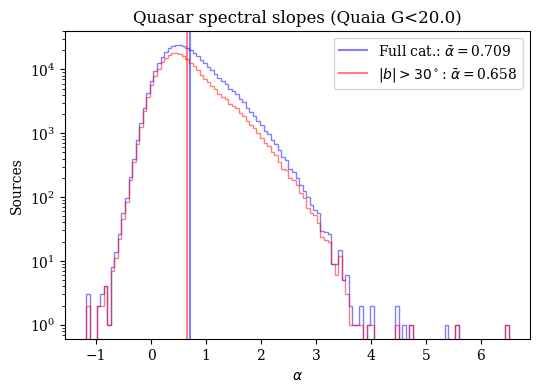

In [15]:
# plot distribution
fig, ax = plt.subplots(figsize=(6,4))

bins = np.linspace(np.amin(alphas+alphas_blim), np.amax(alphas+alphas_blim),120)

n, _, _ = ax.hist(alphas, bins=bins, color='b', alpha=0.5, histtype='step')
ax.axvline(np.mean(alphas), c='b', alpha=0.5, label=r'Full cat.: $\bar\alpha=$'f'{np.mean(alphas):.3f}')
_, _, _ = ax.hist(alphas_blim, bins=bins, color='r', alpha=0.5, histtype='step')
ax.axvline(np.mean(alphas_blim), c='r', alpha=0.5, label=r'$|b|>30^\circ$: $\bar\alpha=$'f'{np.mean(alphas_blim):.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{maglim})')
ax.legend()

### CatWISE2020 AGNs

In [11]:
catname = 'catwise_agns'
initial_catfn = 'catwise_agns_master.fits'
mag = 'w1'
maglim = 16.4
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=30)
del d.initial_cattab
d.cut_mag()
# compute alphas
alphas = [compute_alpha_wise(d.table['w12'][i]) for i in range(len(d.table))]
print(np.mean(alphas))

# with galactic plane masking
d.cut_galactic_plane()
alphas_blim = [compute_alpha_wise(d.table['w12'][i]) for i in range(len(d.table))]
print(np.mean(alphas_blim))

alphas_S21 = alphas_blim

loading initial catalog, catwise_agns_master.fits
3079981 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.
1.3255579404806301
cut |b| <= 30 -> 1400045 sources left.
1.2696084496819087


In [14]:
# catwise_agns_master has masked individual sources (including galactic center) but not the galactic plane
tab_masked = Table.read(
    '/scratch/aew492/lss-dipoles_results/data/catalogs/catwise_agns/catwise_agns_master.fits', format='fits')
# mask the galactic plane, make mag cut, and cut out low w1cov
tab_masked = tab_masked[(np.abs(tab_masked['b'])>30) & (tab_masked['w1']<=16.4) & (tab_masked['w1cov'] > 80)]
# compute alphas
alphas_mask = [compute_alpha_wise(tab_masked['w12'][i]) for i in range(len(tab_masked))]

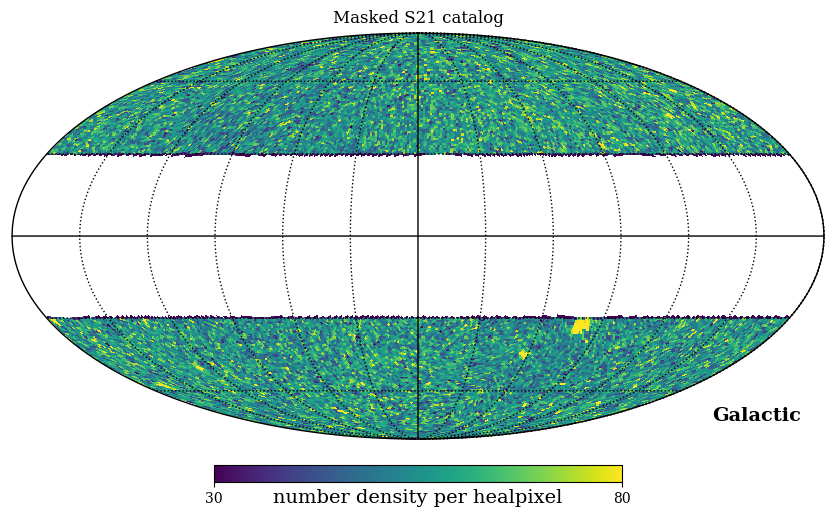

In [15]:
maskedmap = tools.load_catalog_as_map(tab_masked)
maskedmap[maskedmap==0.] = np.nan
tools.mollview(maskedmap, coord=['C','G'], badcolor='w', min=30, max=80, title='Masked S21 catalog')

In [ ]:
# plot distribution
fig, ax = plt.subplots(figsize=(6,4))

bins = np.linspace(np.amin(alphas+alphas_blim+alphas_mask), np.amax(alphas+alphas_blim+alphas_mask),120)

n, _, _ = ax.hist(alphas, bins=bins, color='b', alpha=0.5, histtype='step')
ax.axvline(np.mean(alphas), c='b', alpha=0.5, label=r'Full cat.: $\bar\alpha=$'f'{np.mean(alphas):.3f}')
_, _, _ = ax.hist(alphas_blim, bins=bins, color='r', alpha=0.5, histtype='step')
ax.axvline(np.mean(alphas_blim), c='r', alpha=0.5, label=r'$|b|>30^\circ$: $\bar\alpha=$'f'{np.mean(alphas_blim):.3f}')
_, _, _ = ax.hist(alphas_mask, bins=bins, color='g', alpha=0.5, histtype='step')
ax.axvline(np.mean(alphas_mask), c='g', alpha=0.5, label=r'$|b|>30^\circ$ + masks: $\bar\alpha=$'f'{np.mean(alphas_mask):.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (CatWISE AGNs W1<{maglim}')
ax.legend()

### number-count slope

In [ ]:
catname = 'quaia'
initial_catfn = 'quaia_G20.5_zsplit2bin0.fits'
mag = 'G'
maglim = 20.5
d = SecrestDipole(catname, initial_catfn, mag, maglim+0.1, blim=30)
del d.initial_cattab
d.cut_mag()
d.cut_galactic_plane()

g = d.table['phot_g_mean_mag']

# count the number of sources in bins of magnitude
width = 0.1
min_g = 19
max_g = 20.5
nmags = int((max_g-min_g)/width)+1
mags = np.linspace(min_g, max_g, nmags)
counts = np.array([np.sum(g<=mag) for mag in mags])

In [ ]:
mags_quaia = mags
counts_quaia = counts

In [ ]:
bounds = (-5,-7)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(mags, counts, 'k.-', lw=0.5)
ax.axvline(20., color='k', alpha=0.3, lw=1)
ax.plot(mags[bounds[0]], counts[bounds[0]], marker='x', color='r')
ax.plot(mags[bounds[1]], counts[bounds[1]], marker='x', color='r')
ax.grid(lw=0.5, alpha=0.5)

ax.set_yscale('log')
ax.set_xlabel('G')
ax.set_ylabel('N < G')
ax.set_title('Quaia (G<20.5) G number counts')

In [ ]:
# slope of interest:
dlogN = np.log10(counts[bounds[0]])-np.log10(counts[bounds[1]])
dmags = mags[bounds[0]]-mags[bounds[1]]
x = 2.5*(dlogN)/dmags
x

In [ ]:
EllisBaldwin(x, 0.7652194002286588)

In [ ]:
catname = 'catwise_agns'
initial_catfn = 'catwise_agns_master.fits'
mag = 'w1'
maglim = 16.4
d = SecrestDipole(catname, initial_catfn, mag, maglim+0.1, blim=30)
del d.initial_cattab
d.cut_mag()
d.cut_galactic_plane()

w1 = d.table['w1']

# count the number of sources in bins of magnitude
width = 0.1
min_w1 = 15.
max_w1 = 16.5
nmags = int((max_w1-min_w1)/width)+1
mags = np.linspace(min_w1, max_w1, nmags)
counts = np.array([np.sum(w1<=mag) for mag in mags])

In [ ]:
mags_S21 = mags
counts_S21 = counts

Text(0.5, 1.0, 'Catwise AGNs W1 number counts')

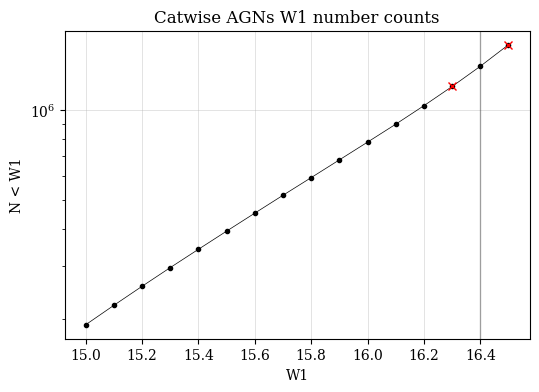

In [24]:
bounds = (-1,-3)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(mags, counts, 'k.-', lw=0.5)
ax.axvline(16.4, color='k', alpha=0.3, lw=1)
ax.plot(mags[bounds[0]], counts[bounds[0]], marker='x', color='r')
ax.plot(mags[bounds[1]], counts[bounds[1]], marker='x', color='r')
ax.grid(lw=0.5, alpha=0.5)

ax.set_yscale('log')
ax.set_xlabel('W1')
ax.set_ylabel('N < W1')
ax.set_title('Catwise AGNs W1 number counts')

### plot

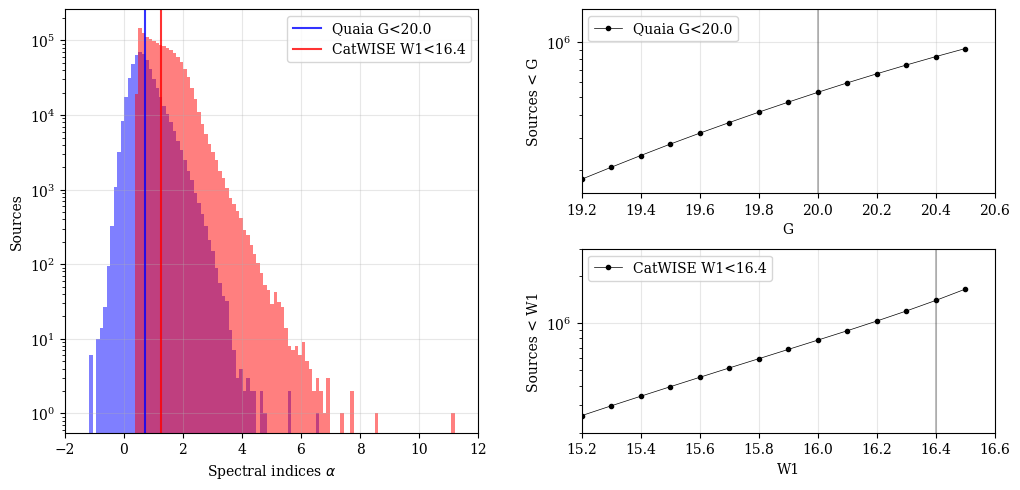

In [47]:
fig = plt.figure(figsize=(12,5.5))

gs = mpl.gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.3)

ax0 = fig.add_subplot(gs[:,0])
bins = np.linspace(np.amin(np.append(alphas_quaia,alphas_S21)), np.amax(np.append(alphas_quaia,alphas_S21)),120)
kwargs = dict(bins=bins, alpha=0.5)
_, _, _ = ax0.hist(alphas_quaia, color='b', **kwargs)
_, _, _ = ax0.hist(alphas_mask, color='r', **kwargs)
ax0.axvline(np.mean(alphas_quaia), c='b', alpha=0.8, label='Quaia G<20.0')
ax0.axvline(np.mean(alphas_mask), c='r', alpha=0.8, label='CatWISE W1<16.4')
ax0.set_xlim(-2,12)
ax0.set_xlabel(r'Spectral indices $\alpha$')
ax0.set_ylabel('Sources')

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(mags_quaia, counts_quaia, 'k.-', lw=0.5, label='Quaia G<20.0')
ax1.axvline(20., color='k', alpha=0.3, lw=1.2)
# ax1.plot(mags_quaia[-5], counts_quaia[-5], marker='x', color='r')
# ax1.plot(mags_quaia[-7], counts_quaia[-7], marker='x', color='r')
ax1.set_xlim(19.2,20.6)
ax1.set_ylim(1.5e5,1.5e6)
ax1.set_xlabel('G')
ax1.set_ylabel('Sources < G')

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(mags, counts, 'k.-', lw=0.5, label='CatWISE W1<16.4')
ax2.axvline(16.4, color='k', alpha=0.3, lw=1.2)
# ax2.plot(mags[-1], counts[-1], marker='x', color='r')
# ax2.plot(mags[-3], counts[-3], marker='x', color='r')
ax2.set_xlim(15.2,16.6)
ax2.set_ylim(2e5,3e6)
ax2.set_xlabel('W1')
ax2.set_ylabel('Sources < W1')

for ax in [ax0,ax1,ax2]:
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    ax.legend()
ax1.legend(loc=2)